In [1]:
import pandas as pd
import numpy as np
from numpy import array
from skimage.io import imshow
from sklearn import metrics as mt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from keras.layers import Reshape
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import seaborn as sns
from keras.models import load_model
import h5py

/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_wh = 64
NUM_CLASSES = 88

In [3]:
#Example of cade to load the data generated from hdf5
hdf5_f = h5py.File("./Data/characters_all_64x64.hdf5", mode='r')

X = hdf5_f["X_train_aug"]
y = hdf5_f["y_train_aug"]
# print(X.shape, y.shape)
X_train = np.copy(X)
y_train = np.copy(y)

X = hdf5_f["X_test_aug"]
y = hdf5_f["y_test_aug"]
# print(X.shape, y.shape)
X_test = np.copy(X)
y_test = np.copy(y)

hdf5_f.close()

In [4]:
one_hot = LabelBinarizer()
y_train_ohe = one_hot.fit_transform(y_train)
y_test_ohe = one_hot.fit_transform(y_test)
y_train_ohe.shape

(2705457, 88)

In [5]:
classes = [chr(x) for x in sorted(set(y_test))]

b


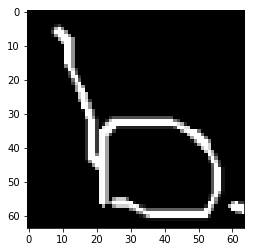

In [5]:
i=3
print(chr(y_train[i]))
plt.imshow(X_train[i,0,:,:].astype(np.float32), cmap='gray')
plt.show()

In [35]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    data_format="channels_first")

datagen.fit(X_train)

In [36]:
cnn = Sequential()
cnn.add(Conv2D(filters=32,
                input_shape = (1, img_wh,img_wh),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 64, 32)         18464     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 64, 64)         18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 32, 32)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 32, 32)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [37]:
# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/1024), # how many generators to go through per epoch
                   epochs=250, verbose=5,
                   validation_data=(X_test, y_test_ohe)
                  )


Epoch 1/1


In [11]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(70,30))
    plt.rcParams.update({'font.size': 12})
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.title(title_text+'{:.4f}'.format(acc))
    plt.show()
    plt.savefig('confusion_matrix.png')

In [96]:
summarize_net(cnn, X_test, y_test, title_text='CNN:')

In [86]:
# save model to disk
cnn.save('cnn.h5')


----

Import model from disk:

In [7]:
from keras.models import load_model

model = load_model('cnn_3.h5')

/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/keras/utils/conv_utils.py:93: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


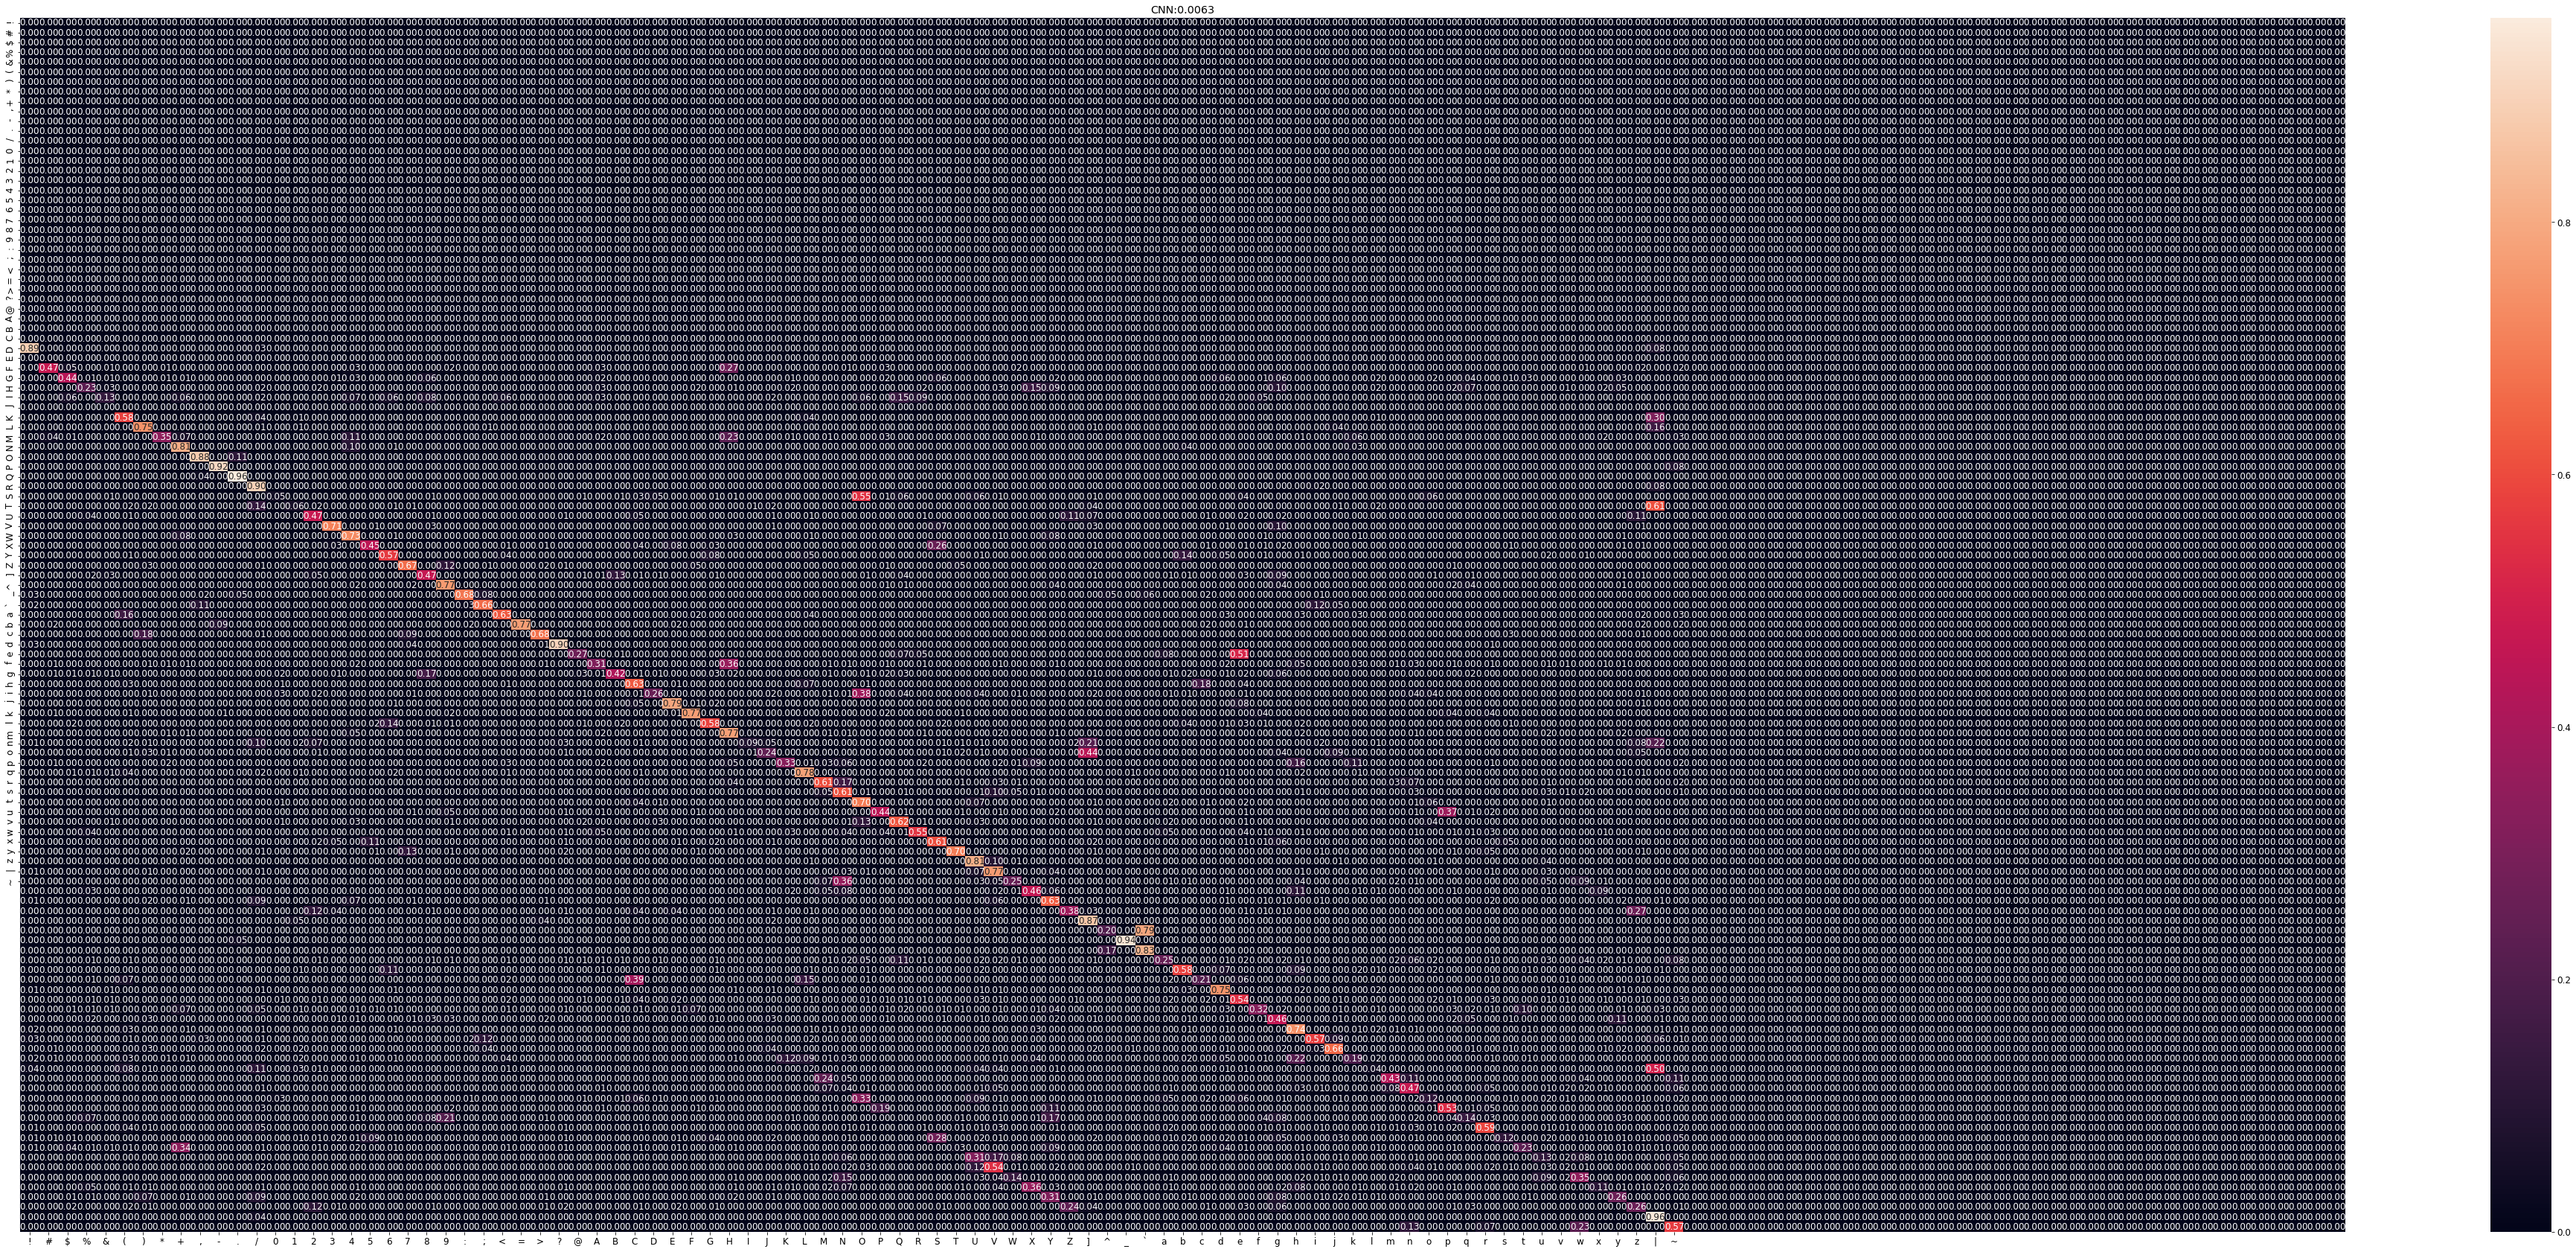

In [33]:
# summarize_net(model, X_test, y_test, title_text='CNN:')

plt.figure(figsize=(70,30))
plt.rcParams.update({'font.size': 12})
yhat = np.argmax(model.predict(X_test), axis=1)
acc = mt.accuracy_score(y_test,yhat)
cm = mt.confusion_matrix(y_test,yhat)

num_guessed = np.sum(cm,axis=1)[:,np.newaxis]
num_guessed[num_guessed == 0] = 1
cm = cm/num_guessed

sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.title("CNN:"+'{:.4f}'.format(acc))
plt.show()
plt.savefig('confusion_matrix.png')

In [35]:
acc = mt.accuracy_score(y_test,yhat)
acc

0.006279654126472322

In [39]:
pred = model.predict(X_test)

In [61]:
y_hat = pred.argmax(axis=1)
y_hat

array([15, 11, 25, ...,  6,  6,  6])

In [48]:
y_test_ohe[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])